## Diffusion model:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
from tqdm import tqdm
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
from torchvision.transforms import Compose
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import pandas as pd

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
df = pd.read_pickle('/kaggle/input/resources/sentence_embeddings.pkl')
df

image_path  \
0      ./nature images/seg_train/seg_train/buildings\...   
1      ./nature images/seg_train/seg_train/buildings\...   
2      ./nature images/seg_train/seg_train/buildings\...   
3      ./nature images/seg_train/seg_train/buildings\...   
4      ./nature images/seg_train/seg_train/buildings\...   
...                                                  ...   
14029  ./nature images/seg_train/seg_train/street\996...   
14030  ./nature images/seg_train/seg_train/street\996...   
14031  ./nature images/seg_train/seg_train/street\997...   
14032  ./nature images/seg_train/seg_train/street\998...   
14033  ./nature images/seg_train/seg_train/street\999...   

                                                 caption      label  \
0      there is a black and white photo of a train on...  buildings   
1         buildings in a city with a blue sky and clouds  buildings   
2      arafed apartment building with balconies and b...  buildings   
3      there is a clock that is on the wall of a buil...  buildings   
4      tall buildings with a clock tower in the middl...  buildings   
...                                                  ...        ...   
14029  shadows of people walking down a sidewalk in a...     street   
14030  there is a man standing in front of a store se...     street   
14031  arafed buildings line a cobblestone street in ...     street   
14032  people walking on a city street at night with ...     street   
14033   there is a street sign on a pole on the sidewalk     street   

                                     sentence_embeddings  
0      [tensor(-0.0693), tensor(0.0348), tensor(-0.05...  
1      [tensor(0.0582), tensor(0.0526), tensor(0.0808...  
2      [tensor(-0.0064), tensor(0.0041), tensor(-0.07...  
3      [tensor(-0.0038), tensor(0.1033), tensor(-0.02...  
4      [tensor(0.0244), tensor(0.1126), tensor(0.0187...  
...                                                  ...  
14029  [tensor(0.0129), tensor(0.0299), tensor(0.0649...  
14030  [tensor(-0.0038), tensor(0.0832), tensor(-0.10...  
14031  [tensor(0.0143), tensor(0.0610), tensor(-0.044...  
14032  [tensor(0.0385), tensor(-0.0227), tensor(0.003...  
14033  [tensor(0.0108), tensor(0.0304), tensor(0.0003...  

[14034 rows x 4 columns]

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
df['label_encoded'] = label_encoder.fit_transform(df['label'])
df

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


image_path  \
0      ./nature images/seg_train/seg_train/buildings\...   
1      ./nature images/seg_train/seg_train/buildings\...   
2      ./nature images/seg_train/seg_train/buildings\...   
3      ./nature images/seg_train/seg_train/buildings\...   
4      ./nature images/seg_train/seg_train/buildings\...   
...                                                  ...   
14029  ./nature images/seg_train/seg_train/street\996...   
14030  ./nature images/seg_train/seg_train/street\996...   
14031  ./nature images/seg_train/seg_train/street\997...   
14032  ./nature images/seg_train/seg_train/street\998...   
14033  ./nature images/seg_train/seg_train/street\999...   

                                                 caption      label  \
0      there is a black and white photo of a train on...  buildings   
1         buildings in a city with a blue sky and clouds  buildings   
2      arafed apartment building with balconies and b...  buildings   
3      there is a clock that is on the wall of a buil...  buildings   
4      tall buildings with a clock tower in the middl...  buildings   
...                                                  ...        ...   
14029  shadows of people walking down a sidewalk in a...     street   
14030  there is a man standing in front of a store se...     street   
14031  arafed buildings line a cobblestone street in ...     street   
14032  people walking on a city street at night with ...     street   
14033   there is a street sign on a pole on the sidewalk     street   

                                     sentence_embeddings  label_encoded  
0      [tensor(-0.0693), tensor(0.0348), tensor(-0.05...              0  
1      [tensor(0.0582), tensor(0.0526), tensor(0.0808...              0  
2      [tensor(-0.0064), tensor(0.0041), tensor(-0.07...              0  
3      [tensor(-0.0038), tensor(0.1033), tensor(-0.02...              0  
4      [tensor(0.0244), tensor(0.1126), tensor(0.0187...              0  
...                                                  ...            ...  
14029  [tensor(0.0129), tensor(0.0299), tensor(0.0649...              5  
14030  [tensor(-0.0038), tensor(0.0832), tensor(-0.10...              5  
14031  [tensor(0.0143), tensor(0.0610), tensor(-0.044...              5  
14032  [tensor(0.0385), tensor(-0.0227), tensor(0.003...              5  
14033  [tensor(0.0108), tensor(0.0304), tensor(0.0003...              5  

[14034 rows x 5 columns]

In [8]:
from torch.utils.data import DataLoader, Dataset

In [9]:
class ImageCaptionDataset(Dataset):
    def __init__(self, h5_file, dataframe, transform=None):
        self.h5_file = h5_file
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['images'])

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:

            image = Image.fromarray(f['images'][idx].astype('uint8'), 'RGB')

            label = self.dataframe.iloc[idx]['label_encoded']
        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
import torchvision.transforms as transforms
import h5py
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageCaptionDataset(h5_file='/kaggle/input/resources/images.h5', dataframe=df, transform=transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

In [11]:
from PIL import Image

Batch 1:
Image batch shape: torch.Size([64, 3, 64, 64])


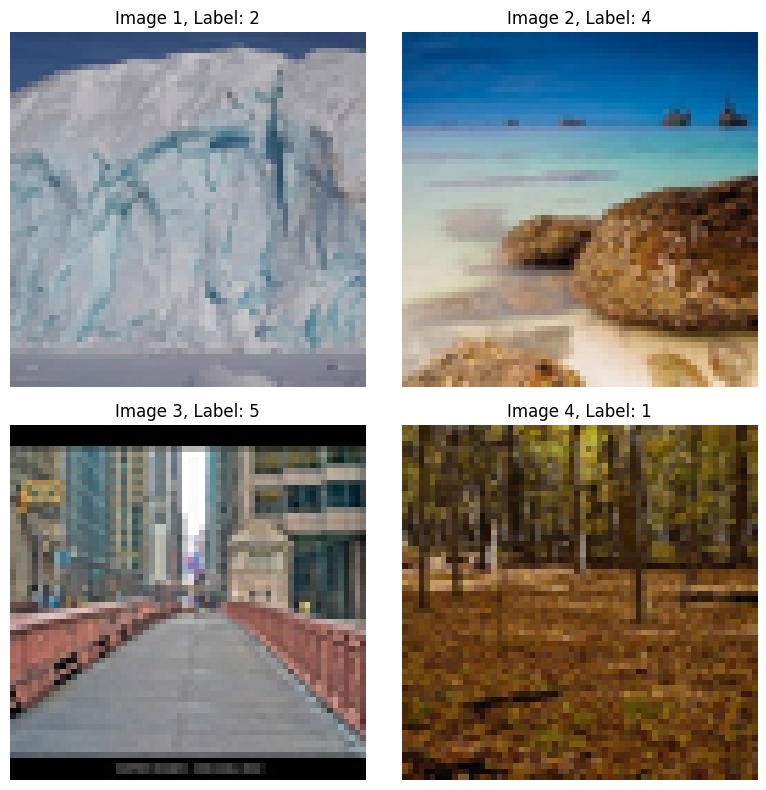

First few labels in this batch:
tensor([2, 4, 5, 1])
Batch 2:
Image batch shape: torch.Size([64, 3, 64, 64])


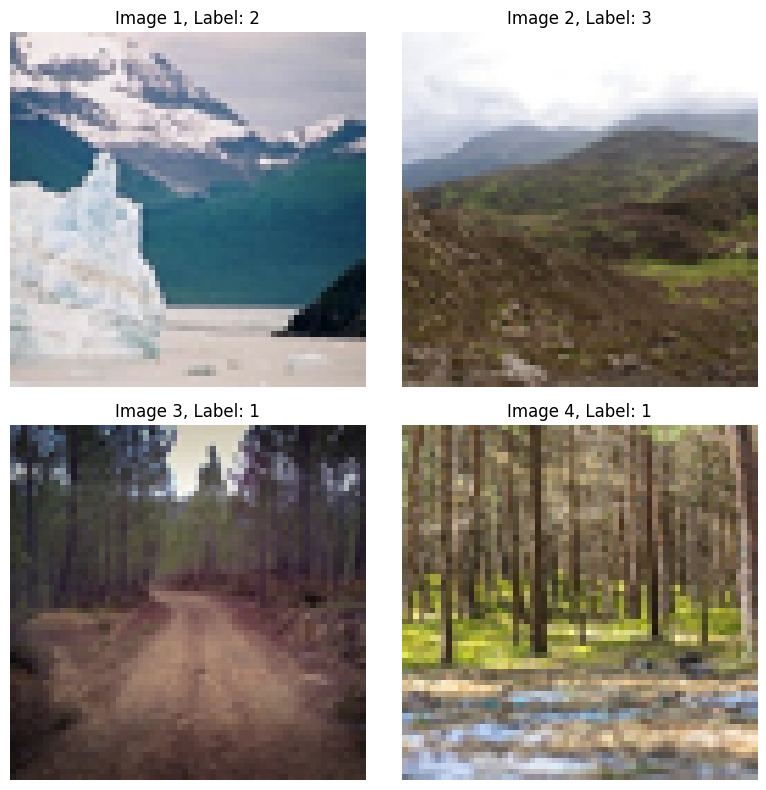

First few labels in this batch:
tensor([2, 3, 1, 1])


In [8]:
max_batches = 2
for batch_idx, (image, labels) in enumerate(dataloader):
    if batch_idx >= max_batches:
        break
    print(f"Batch {batch_idx + 1}:")
    print("Image batch shape:", image.shape)
    # print("Label batch shape:", labels.shape)  # Uncomment this if you want to print the shape of labels

    plt.figure(figsize=(8, 8))
    for i in range(min(4, len(image))):  # Plot up to 4 images from the batch
        plt.subplot(2, 2, i + 1)
        plt.imshow(image[i].permute(1, 2, 0))
        plt.title(f"Image {i + 1}, Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("First few labels in this batch:")
    print(labels[:4])

In [12]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_res = False):
        super().__init__()

        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x):
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [13]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*[ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)])

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [14]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [15]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels=3, n_features = 256, n_classes=6):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_features = n_features
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_features, is_res=True)

        self.down1 = UnetDown(n_features, n_features)
        self.down2 = UnetDown(n_features, 2 * n_features)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2 * n_features)
        self.timeembed2 = EmbedFC(1, 1 * n_features)
        self.contextembed1 = EmbedFC(n_classes, 2 * n_features)
        self.contextembed2 = EmbedFC(n_classes, 1 * n_features)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_features, 2 * n_features, 8, 8),
            nn.GroupNorm(8, 2 * n_features),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_features, n_features)
        self.up2 = UnetUp(2 * n_features, n_features)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_features, n_features, 3, 1, 1),
            nn.GroupNorm(8, n_features),
            nn.ReLU(),
            nn.Conv2d(n_features, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t):
        # x is a noisy image with a context label c at t timestep,
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        cemb1 = self.contextembed1(c).view(-1, self.n_features * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_features * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_features, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_features, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1+ temb1, down2)
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [16]:
def ddpm_schedules(beta_1, beta_2, T):
    assert beta_1 < beta_2 < 1.0, "betas must be in (0, 1)"

    beta_t = (beta_2 - beta_1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta_1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,
        "oneover_sqrta": oneover_sqrta,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
        "sqrtab": sqrtab,
        "sqrtmab": sqrtmab,
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,
    }

In [42]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(self.device)  # t ~ N(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise)

        # MSE between added and predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T))

    def sample(self, n_sample, size, device, class_label, guide_gamma):
        with torch.no_grad():  # Reduces memory usage by not storing gradients
            x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
            c_i = torch.full((n_sample,), class_label, dtype=torch.long).to(device)

            for i in range(self.n_T, 0, -1):
                print(f'sampling timestep {i}', end='\r')
                t_is = torch.full((n_sample, 1, 1, 1), i / self.n_T, dtype=torch.float32).to(device)
                z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
                eps = self.nn_model(x_i, c_i, t_is)
                x_i = (self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                       + self.sqrt_beta_t[i] * z)

            # Only return the final image
            return x_i[-1].detach().cpu()

In [19]:
n_epoch = 20
batch_size = 64
n_T = 1000
device = "cuda:0"
n_classes = 6
n_features = 128
lr = 1e-4
save_dir = '/kaggle/working/'
gammas_test = [0.0, 0.5, 2.0]

In [20]:
device = 'cuda:0'

In [15]:
torch.cuda.is_available()

True

In [67]:
# model = DDPM(nn_model=ContextUnet(in_channels=3, n_features=n_features, n_classes=6), betas=(1e-4, 0.02), n_T=n_T, device=device).to(device)

In [31]:
model = torch.load('/kaggle/input/models/model19.pt')

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [22]:
# if not os.path.exists(save_dir):
#    os.makedirs(save_dir)

In [39]:
def animate_diffusion(i, x_gen_store):
    print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end = '\r')
    plots = []
    for row in range(int(n_sample/n_classes)):
        for col in range(n_classes):
            axs[row, col].clear()
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0], cmap = 'gray', vmin = (-x_gen_store[i]).min(), vmax = (-x_gen_store[i]).max()))
    return plots

In [33]:
for e in range(1, n_epoch):
    print(f'epoch {e+19}')
    model.train()

    optimizer.param_groups[0]['lr'] = lr*(1-e/n_epoch)

    pbar = tqdm(dataloader)
    loss_ema = None # exponential moving average
    for x, y in pbar:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        loss = model(x, y)
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optimizer.step()

    if e % 5 == 0 and e != 0:
        torch.save(model, f'/kaggle/working/model{e+19}.pt')

epoch 20


loss: 0.0196: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 21


loss: 0.0203: 100%|██████████| 220/220 [01:54<00:00,  1.92it/s]


epoch 22


loss: 0.0194: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 23


loss: 0.0194: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 24


loss: 0.0209: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 25


loss: 0.0220: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 26


loss: 0.0205: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 27


loss: 0.0221: 100%|██████████| 220/220 [01:54<00:00,  1.91it/s]


epoch 28


loss: 0.0205: 100%|██████████| 220/220 [01:54<00:00,  1.92it/s]


epoch 29


loss: 0.0204: 100%|██████████| 220/220 [01:54<00:00,  1.92it/s]


epoch 30


loss: 0.0198: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 31


loss: 0.0218: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 32


loss: 0.0202: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 33


loss: 0.0194: 100%|██████████| 220/220 [01:54<00:00,  1.92it/s]


epoch 34


loss: 0.0212: 100%|██████████| 220/220 [01:54<00:00,  1.92it/s]


epoch 35


loss: 0.0205: 100%|██████████| 220/220 [01:54<00:00,  1.91it/s]


epoch 36


loss: 0.0171: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 37


loss: 0.0217: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


epoch 38


loss: 0.0203: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


In [55]:
# torch.save(model, f'/kaggle/working/model19.pt')

In [77]:
model = torch.load('/kaggle/input/models/model19.pt')

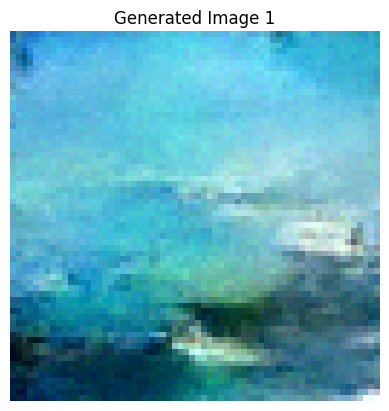

Save this image? (yes/no):  


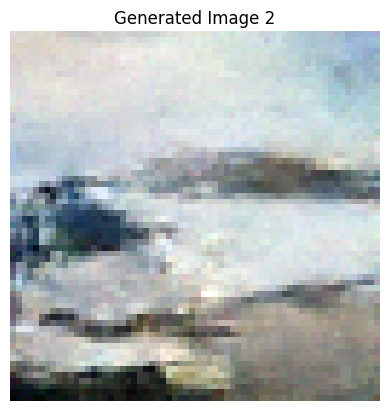

Save this image? (yes/no):  


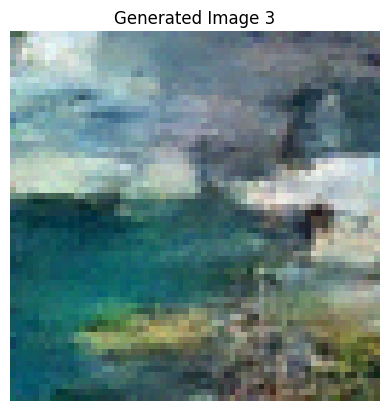

Save this image? (yes/no):  yes
Enter name:  sea4


In [87]:
model.eval()
model.to(device)

n_samples = 10
class_label = 1
generated_images = []
saved_image = False

while not saved_image:
    
    generated_images = []

    for _ in range(n_samples):
        image = model.sample(1, (3, 64, 64), device, class_label=4, guide_gamma=0.0)
        generated_images.append(image.squeeze(0).cpu().detach())

    for i, img_tensor in enumerate(generated_images):
        img = img_tensor.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Generated Image {i+1}")
        plt.show()
        
        inp = input("Save this image? (yes/no): ")
        if inp == 'yes':
            name = input('Enter name: ')
            plt.imsave(f"{name}.png", img)
            saved_image = True
            break